In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Подготовка обезличенного куска

In [87]:
import os
print(os.listdir("./input"))

['sample.csv', 'tablespace_data.csv']


In [52]:
tablespace_data = pd.read_csv("./input/tablespace_data.csv", sep='\t', decimal=',')

In [53]:
tablespace_data['ROLLUP_TIMESTAMP'] = pd.to_datetime(tablespace_data['ROLLUP_TIMESTAMP'])
tablespace_data = tablespace_data.set_index('ROLLUP_TIMESTAMP')
tablespace_data = tablespace_data.sort_values(by=['ROLLUP_TIMESTAMP'])

In [54]:
tablespace_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 287609 entries, 2018-01-05 to 2020-12-06
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DATABASE           287609 non-null  object 
 1   TARGET_GUID        287609 non-null  object 
 2   USED_SIZE_GB       287609 non-null  float64
 3   ALLOCATED_SIZE_GB  287609 non-null  float64
dtypes: float64(2), object(2)
memory usage: 11.0+ MB


In [41]:
tablespace_data[['USED_SIZE_TB','ALLOCATED_SIZE_TB']].describe()

,USED_SIZE_TB,ALLOCATED_SIZE_TB
count,287609.000000,287609.000000
mean,1227.600219,2002.833209
std,4804.680841,6776.561516
min,0.817000,1.318000
25%,7.200000,31.817000
50%,53.021000,154.196000
75%,352.583000,849.196000
max,110827.332000,151702.580000


In [9]:
sample = tablespace_data[tablespace_data['DATABASE'] == 'SMTCNT_alpaca']

In [86]:
sample.to_csv('./input/sample.csv', sep='\t')

## Анализ данных одной БД

In [94]:
sample = pd.read_csv('./input/sample.csv', sep='\t')
sample['ROLLUP_TIMESTAMP'] = pd.to_datetime(sample['ROLLUP_TIMESTAMP'])
sample = sample.set_index('ROLLUP_TIMESTAMP')
sample = sample.sort_values(by=['ROLLUP_TIMESTAMP'])

USED_SIZE_GB - физический развер данных БД
ALLOCATED_SIZE_GB - размер файлов БД

In [95]:
sample.head()

,DATABASE,TARGET_GUID,USED_SIZE_GB,ALLOCATED_SIZE_GB
ROLLUP_TIMESTAMP,,,,
2018-01-06,SAMPLEDB_servername,B221C5FFB7320E1E9D0021DED3A03E6E,21675.288,32356.774
2018-01-07,SAMPLEDB_servername,B221C5FFB7320E1E9D0021DED3A03E6E,25420.149,32356.774
2018-01-08,SAMPLEDB_servername,B221C5FFB7320E1E9D0021DED3A03E6E,28169.221,32548.769
2018-01-09,SAMPLEDB_servername,B221C5FFB7320E1E9D0021DED3A03E6E,24272.294,28703.022
2018-01-10,SAMPLEDB_servername,B221C5FFB7320E1E9D0021DED3A03E6E,22125.374,26844.327


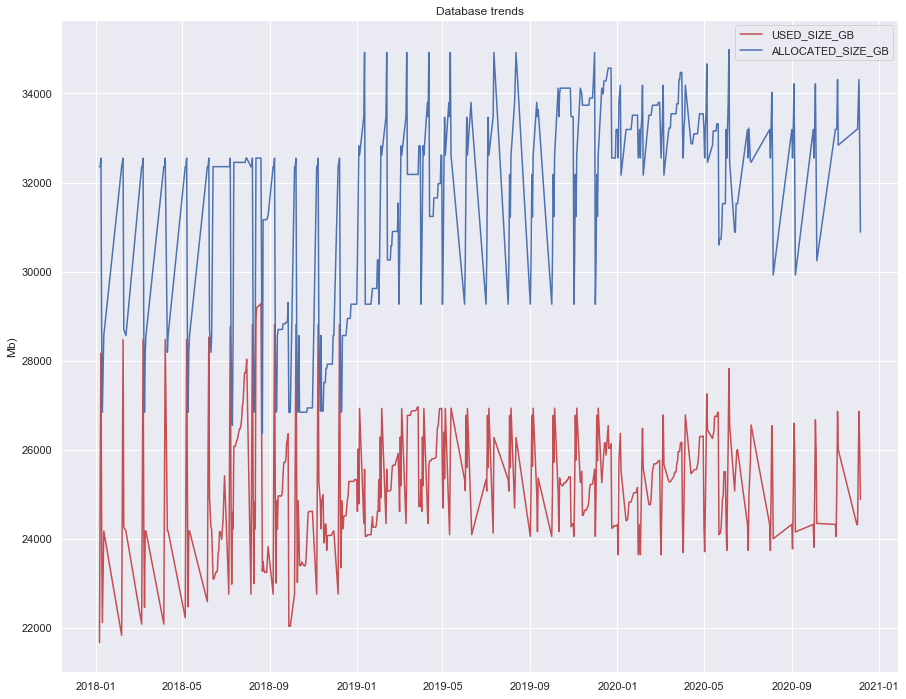

In [97]:
plt.figure(figsize=(15, 12))
plt.plot(sample.index, sample['USED_SIZE_GB'], 'r-', label = 'USED_SIZE_GB')
plt.plot(sample.index, sample['ALLOCATED_SIZE_GB'], 'b-', label = 'ALLOCATED_SIZE_GB')
plt.title('Database trends')
plt.ylabel('Mb)');
plt.legend();
plt.show()

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

In [14]:
sample.set_index('ROLLUP_TIMESTAMP', inplace=True)

In [106]:
sample.index

DatetimeIndex(['2018-01-06', '2018-01-07', '2018-01-08', '2018-01-09',
               '2018-01-10', '2018-01-12', '2018-02-06', '2018-02-08',
               '2018-02-09', '2018-02-12',
               ...
               '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04',
               '2020-11-05', '2020-12-01', '2020-12-02', '2020-12-04',
               '2020-12-05', '2020-12-06'],
              dtype='datetime64[ns]', name='ROLLUP_TIMESTAMP', length=554, freq=None)

In [107]:
#усреднение за месяц
sample_month = sample['USED_SIZE_GB'].resample('MS').mean()

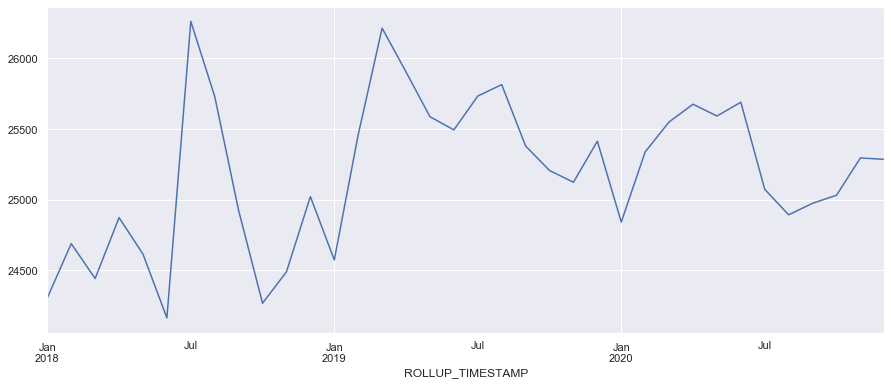

In [108]:
sample_month.plot(figsize=(15, 6))
plt.show()

Text(0.5, 1.0, 'detrended by subtracting the least squares fit')

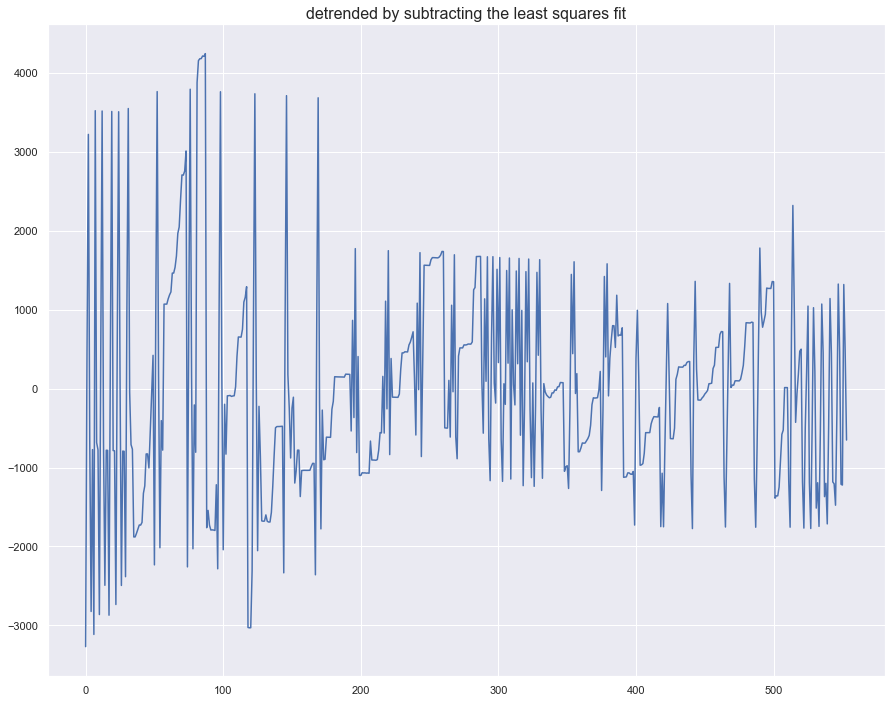

In [103]:
# с помощью scipy убираем компонент тренда, чтобы показать колебания
from scipy import signal
detrended = signal.detrend(sample.USED_SIZE_GB.values)
plt.figure(figsize=(15, 12))
plt.plot(detrended)
plt.title('detrended by subtracting the least squares fit', fontsize=16)

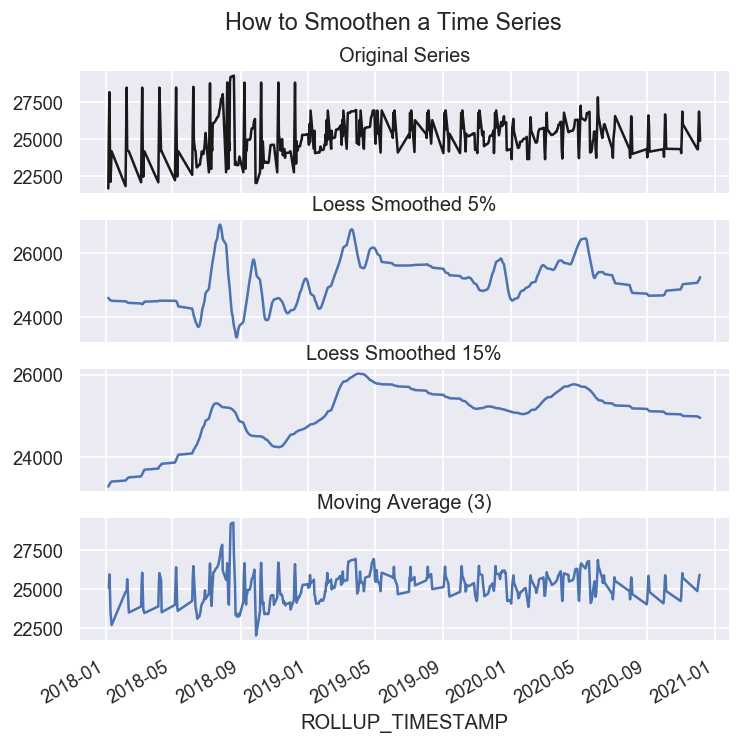

In [35]:
# сглаживания для наглядной визуализации
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# бегущее среднее
sample_ma = sample.USED_SIZE_GB.rolling(3, center=True, closed='both').mean()

# локальная регрессия (5% и 15%)
sample_loess_5 = pd.DataFrame(lowess(sample.USED_SIZE_GB, np.arange(len(sample.USED_SIZE_GB)), frac=0.05)[:, 1], index=sample.index, columns=['USED_SIZE_GB'])
sample_loess_15 = pd.DataFrame(lowess(sample.USED_SIZE_GB, np.arange(len(sample.USED_SIZE_GB)), frac=0.15)[:, 1], index=sample.index, columns=['USED_SIZE_GB'])

fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
sample['USED_SIZE_GB'].plot(ax=axes[0], color='k', title='Original Series')
sample_loess_5['USED_SIZE_GB'].plot(ax=axes[1], title='Loess Smoothed 5%')
sample_loess_15['USED_SIZE_GB'].plot(ax=axes[2], title='Loess Smoothed 15%')
sample_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

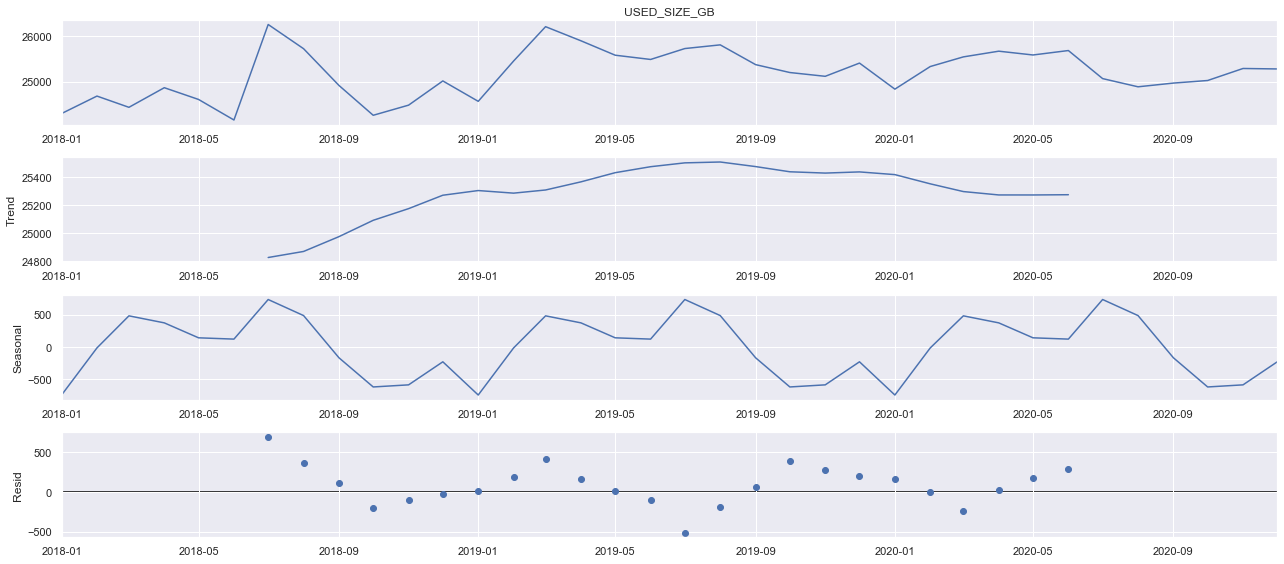

In [109]:
# извлечение тренда, сезонности и шума
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(sample_month, model='additive')
fig = decomposition.plot()
plt.show()

## Autoregressive Integrated Moving Average
ARIMA models are denoted with the notation ARIMA(p, d, q) - three parameters account for seasonality, trend, and noise in data
https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [63]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [68]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sample_month,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:810.8132907263955
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:518.6721654099156
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:369.23593951339944


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:167.0305418083753
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:383.9525381622139
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:355.285483257531
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:182.30097388668534
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:168.43845068016245
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:765.8744186641746
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:494.97810035378706
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:342.8117282259891
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:152.17970526466868
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:384.40348334544365


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:340.4146005035409
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:180.10461994859924
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:147.14380685456013
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:526.2118294459841
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:319.12720871935494
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:346.3998872783979
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:153.21169223294987
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:337.8234378136888
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:319.2512566369887
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:168.3202762925716
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:155.18682733346196
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:510.91032542671405
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:301.97195745406805
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:328.78008594609196
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:131.89208206778764
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:331.10623441695503
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:298.7054750266159
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:166.7328550943633


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:333.28937099748714
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:167.37798302911816
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:149.11047527177953
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:527.2582411898712
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:320.66647595601023
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:347.6814356732783
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:155.18423041577603
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:319.9442620897747
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:320.7396063725362
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:155.20640580188942
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:157.1629426606687
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:506.09071816920743
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:303.2444582461265
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:330.774716829613
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:132.61331567937543
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:321.21672819055186
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:301.0756422939677
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:153.210003273046
ARI

In [ ]:
# минимально ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:131.89208206778764

In [69]:
mod = sm.tsa.statespace.SARIMAX(sample_month,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7238      0.138     -5.260      0.000      -0.993      -0.454
ma.S.L12       0.5741      0.536      1.072      0.284      -0.476       1.624
sigma2      5.874e+04   4.37e+04      1.346      0.178   -2.68e+04    1.44e+05


ValueError: operands could not be broadcast together with shapes (9,) (7,) (9,) 

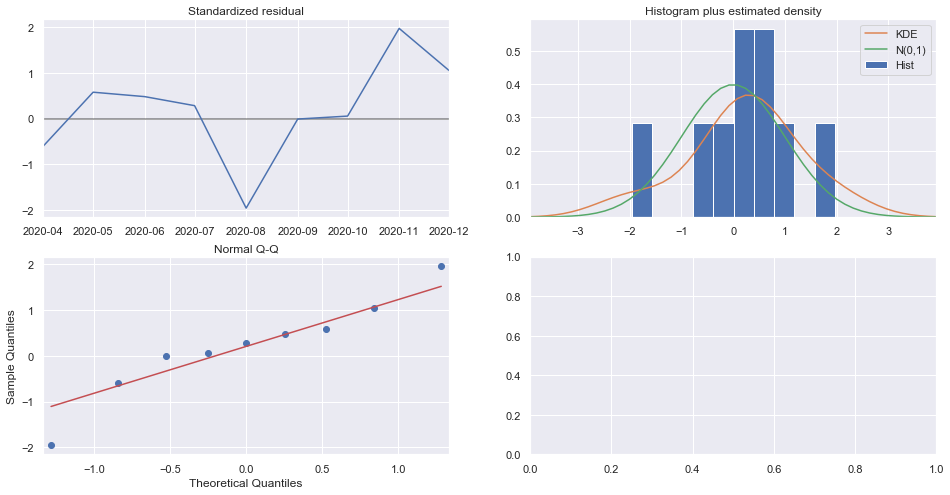

In [70]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#предсказания с начала 2020 и сравнение с рельными данными
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = sample_month['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('USED_SIZE_GB')
plt.legend()
plt.show()

## Оценка ошибки

In [83]:
sample_month_forecasted = pred.predicted_mean
sample_month_truth = sample_month['2020-01-01':]
mse = ((sample_month_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 222309.66


In [84]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 471.5


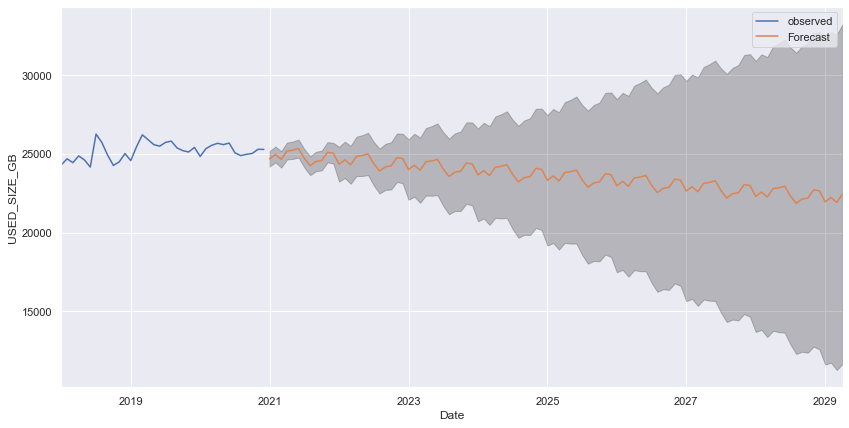

In [110]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = sample_month.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('USED_SIZE_GB')
plt.legend()
plt.show()